In [1]:
'''
establish expected image parameters, training, validation locations
'''

# expected image size
img_width, img_height = 256, 256

# folder containing the images on which the network will train. The train folder 
# has two sub folders, 'yes' and 'no' needle-containing images.
train_data_dir = 'data/train'

# folder containing the validation samples; same folder structure as the training folder
validation_data_dir = 'data/validation'

# how many images to be considered for training
train_samples = 504

# how many images to be used for validation
validation_samples = 63

# set batch size
batch_size = 32

# how many runs will the network make over the training set before starting on validation
epoch = 25

# define input shape and classes
input_shape = (img_width, img_height, 1)
classes = 2


In [5]:
import numpy as np
import sys
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
import keras.backend as K
K.set_image_data_format('channels_last')
K.set_learning_phase(1)

Using TensorFlow backend.


In [6]:


'''
First component of main path:
    The first CONV2D has F1F1 filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be conv_name_base + '2a'. Use 0 as the seed for the random initialization.
    The first BatchNorm is normalizing the channels axis. Its name should be bn_name_base + '2a'.
    Then apply the ReLU activation function. This has no name and no hyperparameters.
Second component of main path:
    The second CONV2D has F2F2 filters of shape (f,f)(f,f) and a stride of (1,1). Its padding is "same" and its name should be conv_name_base + '2b'. Use 0 as the seed for the random initialization.
    The second BatchNorm is normalizing the channels axis. Its name should be bn_name_base + '2b'.
    Then apply the ReLU activation function. This has no name and no hyperparameters.
Third component of main path:
    The third CONV2D has F3F3 filters of shape (1,1) and a stride of (1,1). Its padding is "valid" and its name should be conv_name_base + '2c'. Use 0 as the seed for the random initialization.
    The third BatchNorm is normalizing the channels axis. Its name should be bn_name_base + '2c'. Note that there is no ReLU activation function in this component.
Final step:
    The shortcut and the input are added together.
    Then apply the ReLU activation function. This has no name and no hyperparameters.
'''
def identity_block(X, f, filters, stage, block):
    """
    Implementation of the identity block as defined in Figure 3
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    Returns:
    X -- output of the identity block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value. You'll need this later to add back to the main path.
    X_shortcut = X

    # First component of main path
    X = Conv2D(filters=F1, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    ### END CODE HERE ###

    return X


'''
The CONV2D layer in the shortcut path is used to resize the input xx to a different dimension, so that the dimensions match up in the final addition needed to add the shortcut value back to the main path. (This plays a similar role as the matrix WsWs discussed in lecture.) For example, to reduce the activation dimensions's height and width by a factor of 2, you can use a 1x1 convolution with a stride of 2. The CONV2D layer on the shortcut path does not use any non-linear activation function. Its main role is to just apply a (learned) linear function that reduces the dimension of the input, so that the dimensions match up for the later addition step.
The details of the convolutional block are as follows.
First component of main path:
    The first CONV2D has F1F1 filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be conv_name_base + '2a'.
    The first BatchNorm is normalizing the channels axis. Its name should be bn_name_base + '2a'.
    Then apply the ReLU activation function. This has no name and no hyperparameters.
Second component of main path:
    The second CONV2D has F2F2 filters of (f,f) and a stride of (1,1). Its padding is "same" and it's name should be conv_name_base + '2b'.
    The second BatchNorm is normalizing the channels axis. Its name should be bn_name_base + '2b'.
    Then apply the ReLU activation function. This has no name and no hyperparameters.
Third component of main path:
    The third CONV2D has F3F3 filters of (1,1) and a stride of (1,1). Its padding is "valid" and it's name should be conv_name_base + '2c'.
    The third BatchNorm is normalizing the channels axis. Its name should be bn_name_base + '2c'. Note that there is no ReLU activation function in this component.
Shortcut path:
    The CONV2D has F3F3 filters of shape (1,1) and a stride of (s,s). Its padding is "valid" and its name should be conv_name_base + '1'.
    The BatchNorm is normalizing the channels axis. Its name should be bn_name_base + '1'.
Final step:
    The shortcut and the main path values are added together.
    Then apply the ReLU activation function. This has no name and no hyperparameters.
'''
def convolutional_block(X, f, filters, stage, block, s=2):
    """
    Implementation of the convolutional block as defined in Figure 4
    Arguments:
    X -- input tensor of shape (m, n_H_prev, n_W_prev, n_C_prev)
    f -- integer, specifying the shape of the middle CONV's window for the main path
    filters -- python list of integers, defining the number of filters in the CONV layers of the main path
    stage -- integer, used to name the layers, depending on their position in the network
    block -- string/character, used to name the layers, depending on their position in the network
    s -- Integer, specifying the stride to be used
    Returns:
    X -- output of the convolutional block, tensor of shape (n_H, n_W, n_C)
    """

    # defining name basis
    conv_name_base = 'res' + str(stage) + block + '_branch'
    bn_name_base = 'bn' + str(stage) + block + '_branch'

    # Retrieve Filters
    F1, F2, F3 = filters

    # Save the input value
    X_shortcut = X

    # First component of main path
    X = Conv2D(F1, (1, 1), strides=(s, s), name=conv_name_base + '2a', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2a')(X)
    X = Activation('relu')(X)

    # Second component of main path
    X = Conv2D(filters=F2, kernel_size=(f, f), strides=(1, 1), padding='same', name=conv_name_base + '2b', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2b')(X)
    X = Activation('relu')(X)

    # Third component of main path
    X = Conv2D(filters=F3, kernel_size=(1, 1), strides=(1, 1), padding='valid', name=conv_name_base + '2c', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name=bn_name_base + '2c')(X)

    # Shortcut path
    X_shortcut = Conv2D(F3, (1, 1), strides=(s, s), name=conv_name_base + '1', kernel_initializer=glorot_uniform(seed=0))(X_shortcut)
    X_shortcut = BatchNormalization(axis=3, name=bn_name_base + '1')(X_shortcut)

    # Final step: Add shortcut value to main path, and pass it through a RELU activation (≈2 lines)
    X = Add()([X, X_shortcut])
    X = Activation('relu')(X)

    return X


'''
The details of this ResNet-50 model are:
    Zero-padding pads the input with a pad of (3,3)
    Stage 1:
        The 2D Convolution has 64 filters of shape (7,7) and uses a stride of (2,2). Its name is "conv1".
        BatchNorm is applied to the channels axis of the input.
        MaxPooling uses a (3,3) window and a (2,2) stride.
    Stage 2:
        The convolutional block uses three set of filters of size [64,64,256], "f" is 3, "s" is 1 and the block is "a".
        The 2 identity blocks use three set of filters of size [64,64,256], "f" is 3 and the blocks are "b" and "c".
    Stage 3:
        The convolutional block uses three set of filters of size [128,128,512], "f" is 3, "s" is 2 and the block is "a".
        The 3 identity blocks use three set of filters of size [128,128,512], "f" is 3 and the blocks are "b", "c" and "d".
    Stage 4:
        The convolutional block uses three set of filters of size [256, 256, 1024], "f" is 3, "s" is 2 and the block is "a".
        The 5 identity blocks use three set of filters of size [256, 256, 1024], "f" is 3 and the blocks are "b", "c", "d", "e" and "f".
    Stage 5:
        The convolutional block uses three set of filters of size [512, 512, 2048], "f" is 3, "s" is 2 and the block is "a".
        The 2 identity blocks use three set of filters of size [512, 512, 2048], "f" is 3 and the blocks are "b" and "c".
    The 2D Average Pooling uses a window of shape (2,2) and its name is "avg_pool".
    The flatten doesn't have any hyperparameters or name.
    The Fully Connected (Dense) layer reduces its input to the number of classes using a softmax activation. Its name should be 'fc' + str(classes).
'''
def ResNet50(input_shape=(256, 256, 1), classes=2):
    """
    Implementation of the popular ResNet50 the following architecture:
    CONV2D -> BATCHNORM -> RELU -> MAXPOOL -> CONVBLOCK -> IDBLOCK*2 -> CONVBLOCK -> IDBLOCK*3
    -> CONVBLOCK -> IDBLOCK*5 -> CONVBLOCK -> IDBLOCK*2 -> AVGPOOL -> TOPLAYER
    Arguments:
    input_shape -- shape of the images of the dataset
    classes -- integer, number of classes
    Returns:
    model -- a Model() instance in Keras
    """

    # Define the input as a tensor with shape input_shape
    X_input = Input(input_shape)

    # Zero-Padding
    X = ZeroPadding2D((3, 3))(X_input)

    # Stage 1
    X = Conv2D(64, (7, 7), strides=(2, 2), name='conv1', kernel_initializer=glorot_uniform(seed=0))(X)
    X = BatchNormalization(axis=3, name='bn_conv1')(X)
    X = Activation('relu')(X)
    X = MaxPooling2D((3, 3), strides=(2, 2))(X)

    # Stage 2
    X = convolutional_block(X, f=3, filters=[64, 64, 256], stage=2, block='a', s=1)
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='b')
    X = identity_block(X, 3, [64, 64, 256], stage=2, block='c')

    ### START CODE HERE ###

    # Stage 3
    X = convolutional_block(X, f=3, filters=[128, 128, 512], stage=3, block='a', s=2)
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='b')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='c')
    X = identity_block(X, 3, [128, 128, 512], stage=3, block='d')

    # Stage 4
    X = convolutional_block(X, f=3, filters=[256, 256, 1024], stage=4, block='a', s=2)
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='b')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='c')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='d')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='e')
    X = identity_block(X, 3, [256, 256, 1024], stage=4, block='f')

    # Stage 5
    X = convolutional_block(X, f=3, filters=[512, 512, 2048], stage=5, block='a', s=2)
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='b')
    X = identity_block(X, 3, [512, 512, 2048], stage=5, block='c')

    # Average Pooling
    X = AveragePooling2D((2, 2), name='avg_pool')(X)

    ### END CODE HERE ###

    # output layer
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', name='fc' + str(classes), kernel_initializer=glorot_uniform(seed=0))(X)

    # Create model
    model = Model(inputs=X_input, outputs=X, name='ResNet50')

    return model

model = ResNet50(input_shape = (256, 256, 1), classes = 2)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
#X_train_orig, Y_train_orig, X_test_orig, Y_test_orig, classes = load_dataset()

# Plot the model
plot_model(model, to_file='model.png')

# Normalize image vectors
#X_train = X_train_orig/255.
#X_test = X_test_orig/255.

# Convert training and test labels to one hot matrices
#Y_train = convert_to_one_hot(Y_train_orig, 6).T
#Y_test = convert_to_one_hot(Y_test_orig, 6).T

#print ("number of training examples = " + str(X_train.shape[0]))
#print ("number of test examples = " + str(X_test.shape[0]))
#print ("X_train shape: " + str(X_train.shape))
#print ("Y_train shape: " + str(Y_train.shape))
#print ("X_test shape: " + str(X_test.shape))
#print ("Y_test shape: " + str(Y_test.shape))

In [7]:
'''
develop image augmentation scripts to amplify sample size
'''

from keras.preprocessing.image import ImageDataGenerator

# this is the augmentation configuration we will use for training
# generating many transformed images so that the model can handle real-world variety
train_datagen = ImageDataGenerator(
        rescale=1./255,
        shear_range=0.2,
#        zoom_range=0.2,
        horizontal_flip=True)

# this is the augmentation configuration we will use for testing:
# only rescaling
test_datagen = ImageDataGenerator(rescale=1./255)

# pass images to ImageGenerator to create transformed versions
train_generator = train_datagen.flow_from_directory(
        train_data_dir,
        target_size=(img_width, img_height),
        color_mode="grayscale",
        batch_size=32,
        class_mode='categorical')

validation_generator = test_datagen.flow_from_directory(
        validation_data_dir,
        target_size=(img_width, img_height),
        color_mode="grayscale",
        batch_size=32,
        class_mode='categorical')


Found 504 images belonging to 2 classes.
Found 63 images belonging to 2 classes.


In [8]:
'''
train model and generate history callback
'''

from keras.callbacks import History 

history = History()

history = model.fit_generator(
        train_generator,
        steps_per_epoch = train_samples // batch_size,
        epochs=epoch,
        validation_data = validation_generator,
        validation_steps = validation_samples // batch_size,
        callbacks=[history])

model.save_weights('resnet50-trial.h5')  # always save your weights after training or during training





Epoch 1/25
15/15 [==============================] - 31s 2s/step - loss: 9.8786 - acc: 0.3771 - val_loss: 11.0812 - val_acc: 0.3125
Epoch 2/25
15/15 [==============================] - 15s 991ms/step - loss: 10.9457 - acc: 0.3209 - val_loss: 10.3988 - val_acc: 0.3548
Epoch 3/25
15/15 [==============================] - 12s 799ms/step - loss: 10.6012 - acc: 0.3423 - val_loss: 10.5775 - val_acc: 0.3438
Epoch 4/25
15/15 [==============================] - 12s 798ms/step - loss: 10.7671 - acc: 0.3320 - val_loss: 10.9187 - val_acc: 0.3226
Epoch 5/25
15/15 [==============================] - 12s 794ms/step - loss: 11.1578 - acc: 0.3077 - val_loss: 9.0664 - val_acc: 0.4375
Epoch 6/25
15/15 [==============================] - 12s 795ms/step - loss: 10.5129 - acc: 0.3478 - val_loss: 12.4785 - val_acc: 0.2258
Epoch 7/25
15/15 [==============================] - 12s 800ms/step - loss: 10.8994 - acc: 0.3238 - val_loss: 9.5701 - val_acc: 0.4062
Epoch 8/25
15/15 [==============================] - 12s 806ms

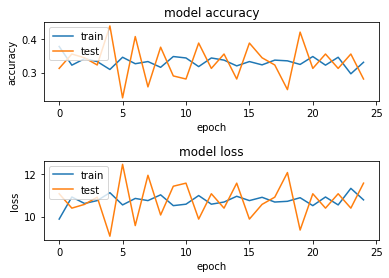

In [9]:
'''
plot training and validation loss and accuracy history
'''

import matplotlib.pyplot as plt  

fig = plt.figure(1)  
fig.subplots_adjust(hspace=.75)

# summarize history for accuracy  
plt.subplot(211)  
plt.plot(history.history['acc'])  
plt.plot(history.history['val_acc'])  
plt.title('model accuracy')  
plt.ylabel('accuracy')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  


# summarize history for loss  
plt.subplot(212)  
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('model loss')  
plt.ylabel('loss')  
plt.xlabel('epoch')  
plt.legend(['train', 'test'], loc='upper left')  
plt.show()  